### Import libraries

In [7]:
import os
import pickle
import time
import random

import pandas as pd
import numpy as np
import sklearn
import matplotlib
from sklearn import tree
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score, recall_score, precision_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
#import autosklearn.classification as classifier
SEED = 42  # or any fixed number

# Set seeds for reproducibility
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
print(torch.cuda.is_available())

True


### Load Dataset

In [9]:
df = pd.read_csv("D:/Machine Predictive Maintenance Classification Dataset/data/predictive_maintenance.csv")

In [10]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### Data Profiling

In [11]:
df.shape

(10000, 10)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [13]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [14]:
total_types = df.shape[0]
low_types = df[df["Type"]=="L"].shape[0]
medium_types = df[df["Type"]=="M"].shape[0]
high_types = df[df["Type"]=="H"].shape[0]

# Calculate percentages
low_percentage = (low_types / total_types) * 100
medium_percentage = (medium_types / total_types) * 100
high_percentage = (high_types / total_types) * 100

print(f"Percentage of products with low quality: {low_percentage}%")
print(f"Percentage of products with medium quality: {medium_percentage}%")
print(f"Percentage of products with high quality: {high_percentage}%")

Percentage of products with low quality: 60.0%
Percentage of products with medium quality: 29.970000000000002%
Percentage of products with high quality: 10.03%


In [15]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [16]:
independent_variables = df.columns[3:8]
independent_variables

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [17]:
dependent_variables = df.columns[8:]
dependent_variables

Index(['Target', 'Failure Type'], dtype='object')

In [18]:
independent_variables[0]

'Air temperature [K]'

In [19]:
df['Target'].unique()

array([0, 1])

In [20]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [21]:
for variable in dependent_variables:
    print(df[variable].value_counts())
    print("***"*8)

Target
0    9661
1     339
Name: count, dtype: int64
************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
************************


### Exploratory data analysis

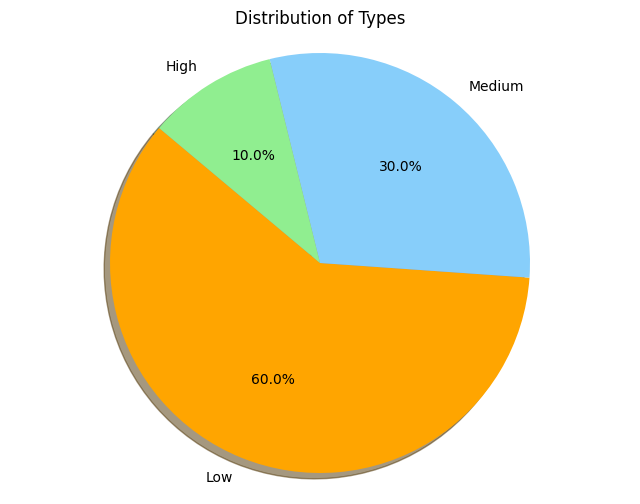

In [22]:
# Data to plot
sizes = [low_percentage, medium_percentage, high_percentage]
labels = ['Low', 'Medium', 'High']
colors = ['orange', 'lightskyblue', 'lightgreen']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Types')

plt.show()


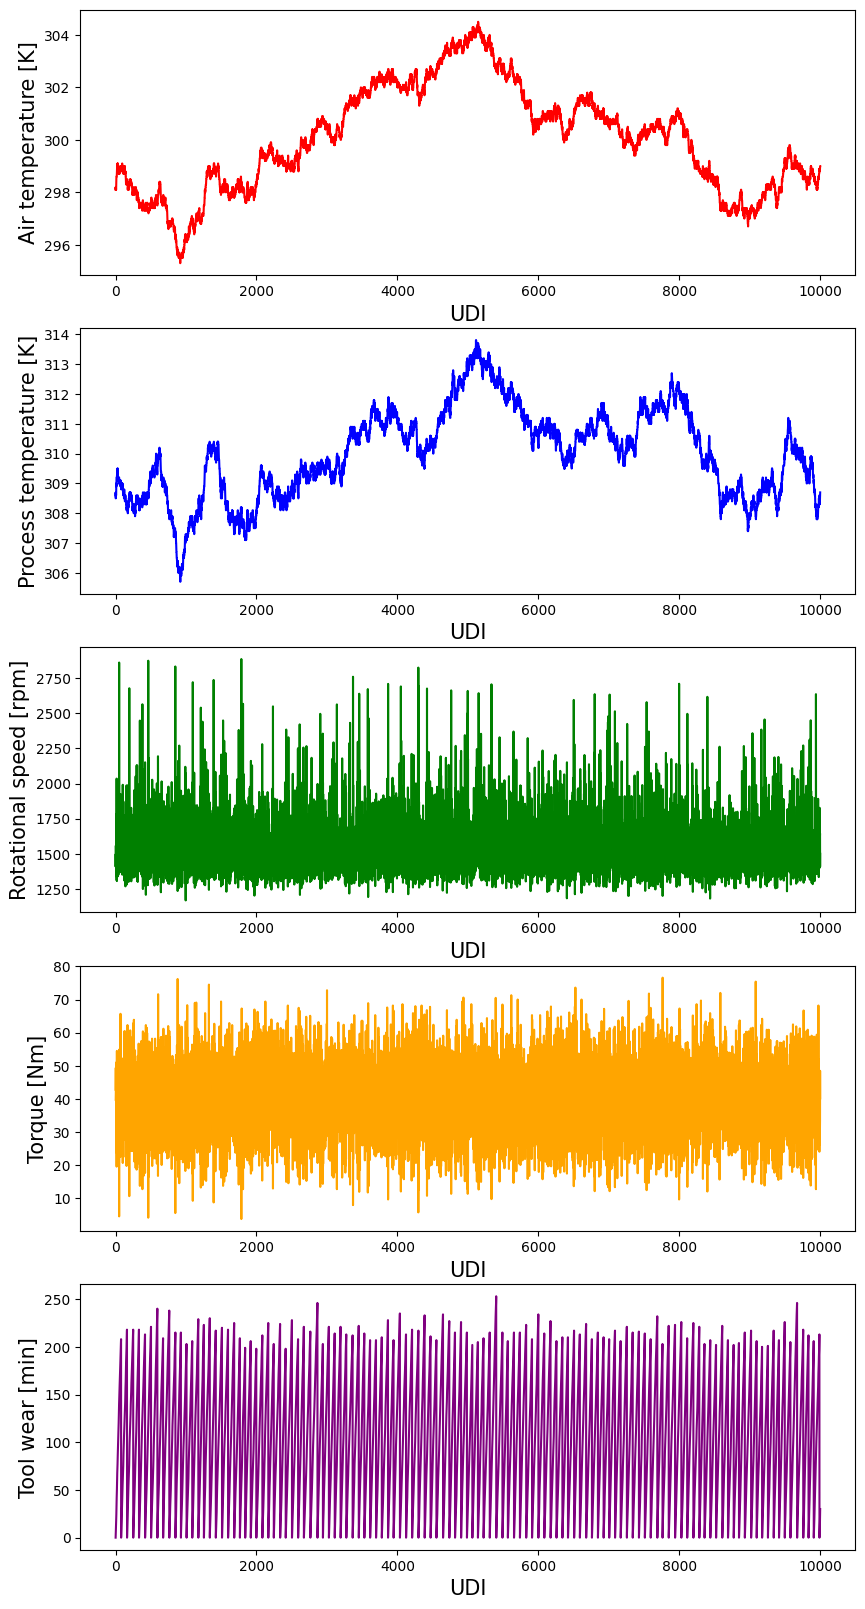

In [23]:
# Visualizing the trends of independent variables
fig, ax = plt.subplots(5,figsize=(10,20))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(5):
    ax[i].plot(df["UDI"],df[independent_variables[i]],color=colors[i])
    ax[i].set_xlabel("UDI",fontsize=15)
    ax[i].set_ylabel(independent_variables[i],fontsize=15)
    # ax[i].legend(independent_variables[i])
plt.show()

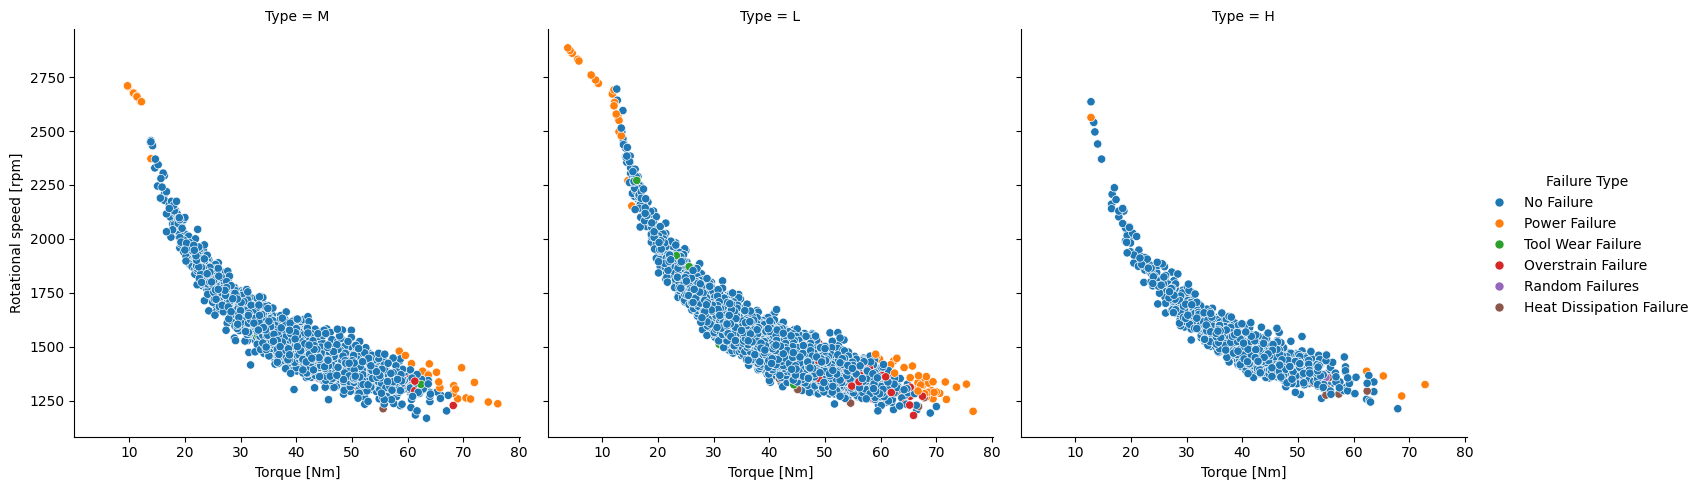

In [24]:
sns.relplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type", col="Type")

Note that at higher torque we can observe tool waer, overstrain, random and heat dissipation failures. At lower torque we observe power failure.

In [25]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [26]:
independent_variables

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [27]:
df['Air temperature [K]']

0       298.1
1       298.2
2       298.1
3       298.2
4       298.2
        ...  
9995    298.8
9996    298.9
9997    299.0
9998    299.0
9999    299.0
Name: Air temperature [K], Length: 10000, dtype: float64

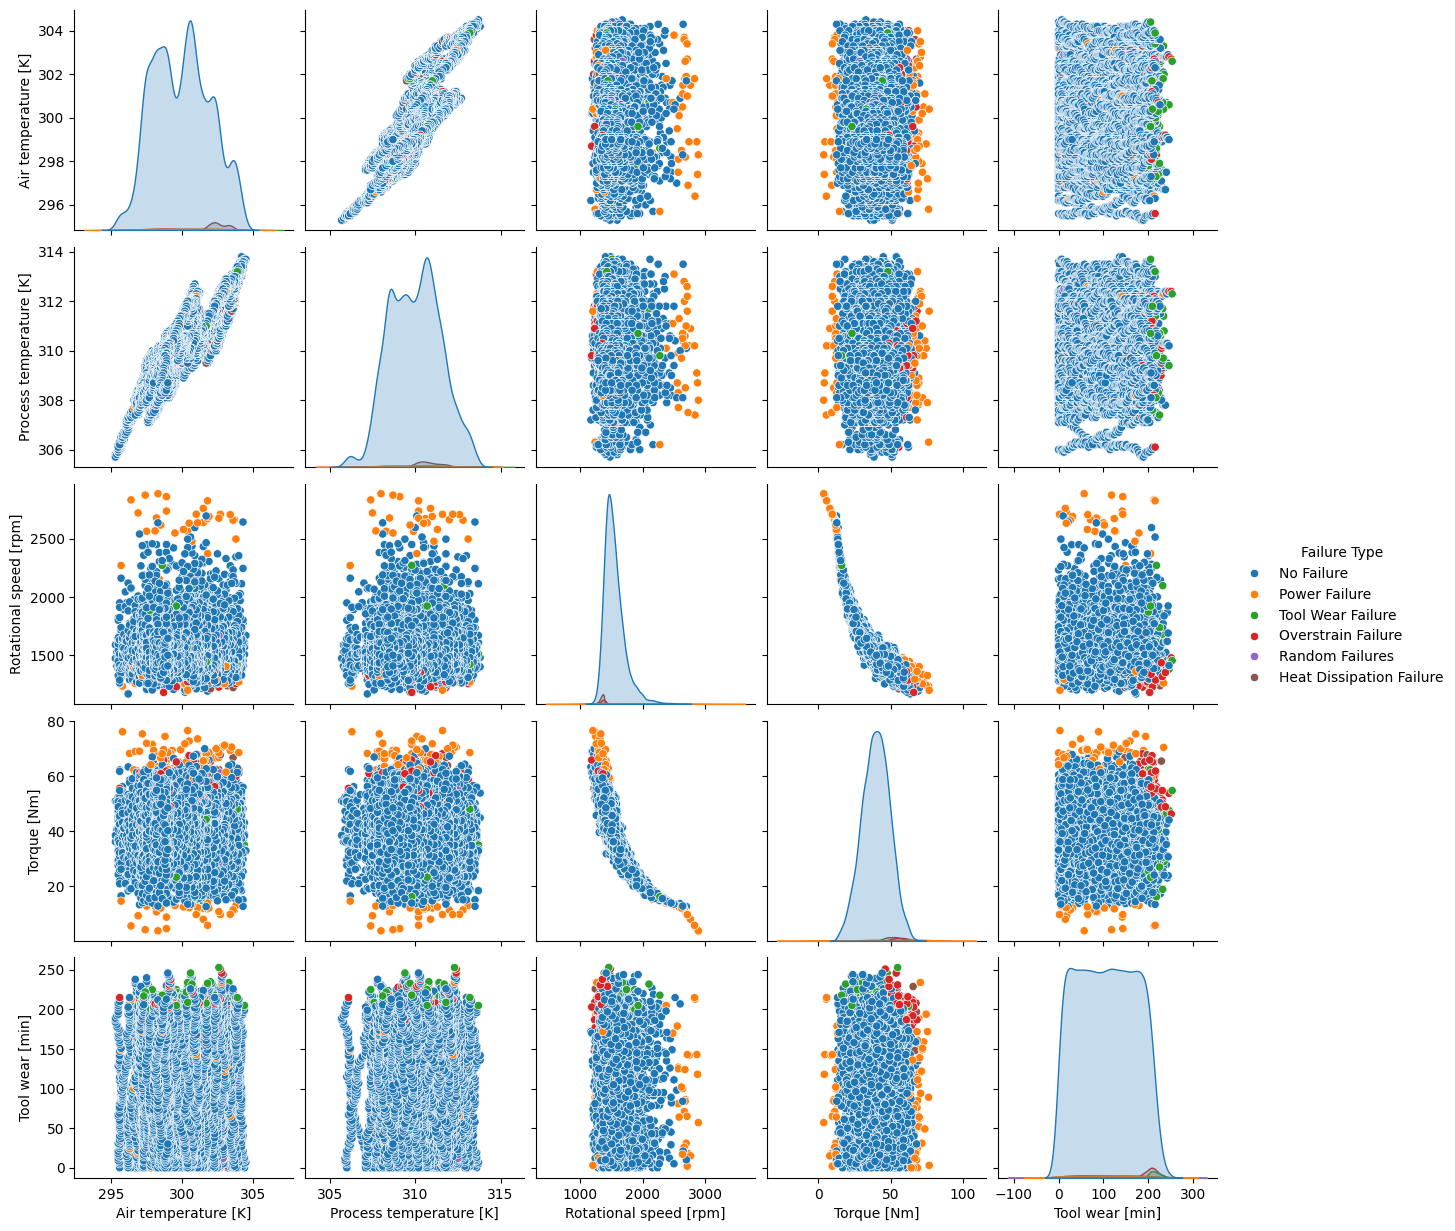

In [28]:
sns.pairplot(df[['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Failure Type']], 
             diag_kind='kde', hue='Failure Type') #it has histograms along the diagonal
                #scatterplots off the diagonal

### Data Preprocessing

In [29]:
new_data = df.copy()

type_encoder = LabelEncoder()
failure_type_encoder = LabelEncoder()

new_data['Type'] = type_encoder.fit_transform(new_data['Type'])
new_data['EncodedFailureType'] = failure_type_encoder.fit_transform(new_data['Failure Type'])

new_data = new_data.drop(columns=['UDI','Product ID'], axis=1)
new_data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,EncodedFailureType
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure,1
9996,0,298.9,308.4,1632,31.8,17,0,No Failure,1
9997,2,299.0,308.6,1645,33.4,22,0,No Failure,1
9998,0,299.0,308.7,1408,48.5,25,0,No Failure,1


In [30]:
print("Type classes:", list(type_encoder.classes_))
print("Failure Type classes:", list(failure_type_encoder.classes_))

Type classes: ['H', 'L', 'M']
Failure Type classes: ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']


In [31]:
# new_data = df.copy()
# scaler = LabelEncoder()
# new_data['Type'] = scaler.fit_transform(new_data['Type'])
# new_data['EncodedFailureType'] = scaler.fit_transform(new_data['Failure Type'])

# new_data = new_data.drop(columns=['UDI','Product ID'], axis=1)
# new_data

In [32]:
for variable in ["EncodedFailureType"]:
    print(new_data[variable].value_counts())

EncodedFailureType
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64


In [33]:
new_data.columns = ['Type','AirTemperature','ProcessTemperature','RotationalSpeed','Torque','ToolWear','Target','FailureType','EncodedFailureType']
new_data

,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType,EncodedFailureType
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure,1
9996,0,298.9,308.4,1632,31.8,17,0,No Failure,1
9997,2,299.0,308.6,1645,33.4,22,0,No Failure,1
9998,0,299.0,308.7,1408,48.5,25,0,No Failure,1


In [34]:
independent_variables = new_data.columns[1:6]
independent_variables

Index(['AirTemperature', 'ProcessTemperature', 'RotationalSpeed', 'Torque',
       'ToolWear'],
      dtype='object')

### Splitting of dataset

In [35]:
X = new_data[independent_variables]
X

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [36]:
y = new_data['EncodedFailureType']
y.unique()

array([1, 3, 5, 2, 4, 0])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [38]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,EncodedFailureType
9069,297.2,308.2,1678,28.1,133,1
2603,299.3,309.2,1334,46.3,31,1
7738,300.5,312.0,1263,60.8,146,1
1579,298.3,308.3,1444,43.8,176,1
5058,303.9,312.9,1526,42.5,194,1
...,...,...,...,...,...,...
5734,302.3,311.8,1369,56.2,208,2
5191,304.0,313.2,1416,46.0,128,1
5390,302.8,312.3,1483,47.2,223,1
860,296.1,306.9,1541,32.6,33,1


In [39]:
# Class distribution in train data
for variable in ["EncodedFailureType"]:
    print(train_data[variable].value_counts())

EncodedFailureType
1    6749
0      89
3      64
2      56
5      31
4      11
Name: count, dtype: int64


In [40]:
X_test.shape, y_test.shape

((3000, 5), (3000,))

In [41]:
data = pd.concat([X_test,y_test], axis=1)
data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,EncodedFailureType
6252,300.8,310.3,1538,36.1,198,1
4684,303.6,311.8,1421,44.8,101,1
1731,298.3,307.9,1485,42.0,117,1
4742,303.3,311.3,1592,33.7,14,1
4521,302.4,310.4,1865,23.9,129,1
...,...,...,...,...,...,...
8014,300.9,312.0,1500,44.2,188,1
1074,297.0,307.9,1595,31.7,170,1
3063,300.0,309.1,1431,45.4,90,1
6487,300.6,309.8,1541,36.2,166,1


In [42]:
# class distribution in test data
for variable in ["EncodedFailureType"]:
    print(data[variable].value_counts())

EncodedFailureType
1    2903
3      31
0      23
2      22
5      14
4       7
Name: count, dtype: int64


### Handling imbalanced dataset using SMOTE
The **Synthetic Minority Oversampling Technique (SMOTE)** addresses imbalanced datasets by synthetically generating new instances for the minority class. Unlike simply duplicating records, SMOTE enhances diversity by creating artificial instances [Link](https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/).  

In [43]:
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [44]:
training_data_resampled =  pd.concat([X_train_resampled, y_train_resampled ], axis=1)
training_data_resampled

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,EncodedFailureType
0,297.200000,308.200000,1678,28.100000,133,1
1,299.300000,309.200000,1334,46.300000,31,1
2,300.500000,312.000000,1263,60.800000,146,1
3,298.300000,308.300000,1444,43.800000,176,1
4,303.900000,312.900000,1526,42.500000,194,1
...,...,...,...,...,...,...
40489,301.362321,310.525147,1526,35.980655,207,5
40490,300.447877,310.217954,1669,30.455115,234,5
40491,301.668934,310.667502,1697,30.433214,223,5
40492,298.820052,308.264341,1507,32.505839,208,5


In [45]:
# class distribution in sampled training data
for variable in ["EncodedFailureType"]:
    print(training_data_resampled[variable].value_counts())

EncodedFailureType
1    6749
5    6749
0    6749
3    6749
2    6749
4    6749
Name: count, dtype: int64


In [46]:
X_train = X_train_resampled.copy()
y_train = y_train_resampled.copy()

In [47]:
X_train.shape, y_train.shape

((40494, 5), (40494,))

### Fit and evaluate multiple classifiers using default settings (no hyperparameter tuning)

#### Logistic Regression

In [48]:
X_train.shape

(40494, 5)

In [49]:
logistic_reg = LogisticRegression(random_state=SEED, max_iter=150, class_weight="balanced")
logistic_reg.fit(X_train,y_train)
y_pred_lr = logistic_reg.predict(X_test)

#Score returns the mean accuracy on the given test data and labels.
lr_train_accuracy = round(logistic_reg.score(X_train,y_train)*100,2)
lr_test_accuracy = round(accuracy_score(y_test,y_pred_lr)*100,2)
print("Logistic Regression Training Accuracy :",lr_train_accuracy,"%")
print("Logistic Regression Test Accuracy :",lr_test_accuracy,"%")
print(classification_report(y_test,y_pred_lr))

confusion_matrix(y_test, y_pred_lr)

Logistic Regression Training Accuracy : 77.86 %
Logistic Regression Test Accuracy : 58.63 %
              precision    recall  f1-score   support

           0       0.04      0.70      0.08        23
           1       1.00      0.58      0.73      2903
           2       0.28      0.64      0.39        22
           3       0.39      1.00      0.56        31
           4       0.00      0.00      0.00         7
           5       0.06      0.86      0.10        14

    accuracy                           0.59      3000
   macro avg       0.29      0.63      0.31      3000
weighted avg       0.97      0.59      0.72      3000



c:\Users\subhi\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[  16,    0,    1,    1,    5,    0],
       [ 385, 1686,   33,   43,  557,  199],
       [   2,    0,   14,    3,    0,    3],
       [   0,    0,    0,   31,    0,    0],
       [   0,    5,    0,    1,    0,    1],
       [   0,    0,    2,    0,    0,   12]])

#### Decision Tree

In [50]:
decision_tree = DecisionTreeClassifier(random_state=SEED, class_weight="balanced")

decision_tree.fit(X_train,y_train)
y_pred_dt = decision_tree.predict(X_test)

dt_train_accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")

print(classification_report(y_test,y_pred_dt))

confusion_matrix(y_test, y_pred_dt)


Training Accuracy : 100.0 %
Model Accuracy Score : 93.97 %
              precision    recall  f1-score   support

           0       0.63      0.96      0.76        23
           1       0.99      0.95      0.97      2903
           2       0.62      0.59      0.60        22
           3       0.71      0.71      0.71        31
           4       0.00      0.00      0.00         7
           5       0.10      0.43      0.16        14

    accuracy                           0.94      3000
   macro avg       0.51      0.61      0.53      3000
weighted avg       0.98      0.94      0.96      3000



array([[  22,    1,    0,    0,    0,    0],
       [  11, 2756,    6,    7,   67,   56],
       [   2,    4,   13,    2,    0,    1],
       [   0,    8,    1,   22,    0,    0],
       [   0,    7,    0,    0,    0,    0],
       [   0,    7,    1,    0,    0,    6]])

#### Random Forest

In [51]:
random_forest = RandomForestClassifier(random_state=SEED, class_weight="balanced")

random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

rf_train_accuracy = round(random_forest.score(X_train, y_train) * 100, 2)
rf_test_accuracy = round(accuracy_score(y_test,y_pred_rf) * 100, 2)

print("Training Accuracy :",rf_train_accuracy ,"%")
print("Model Accuracy Score :",rf_test_accuracy ,"%")

print(classification_report(y_test,y_pred_rf))

confusion_matrix(y_test, y_pred_rf)

Training Accuracy : 100.0 %
Model Accuracy Score : 95.73 %
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        23
           1       0.99      0.97      0.98      2903
           2       0.60      0.68      0.64        22
           3       0.67      0.77      0.72        31
           4       0.00      0.00      0.00         7
           5       0.13      0.50      0.21        14

    accuracy                           0.96      3000
   macro avg       0.51      0.64      0.56      3000
weighted avg       0.98      0.96      0.97      3000



array([[  21,    2,    0,    0,    0,    0],
       [   9, 2805,    8,   11,   25,   45],
       [   0,    5,   15,    1,    0,    1],
       [   0,    6,    1,   24,    0,    0],
       [   0,    6,    0,    0,    0,    1],
       [   0,    6,    1,    0,    0,    7]])

#### SVC

In [52]:
svc = SVC(random_state=SEED, class_weight="balanced")
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

svc_train_accuracy = round(svc.score(X_train, y_train) * 100, 2)
svc_test_accuracy = round(accuracy_score(y_test,y_pred_svc) * 100, 2)

print("Training Accuracy :",svc_train_accuracy ,"%")
print("Model Accuracy Score :",svc_test_accuracy ,"%")

print(classification_report(y_test,y_pred_svc))

confusion_matrix(y_test, y_pred_svc)

Training Accuracy : 72.27 %
Model Accuracy Score : 39.83 %
              precision    recall  f1-score   support

           0       0.06      0.87      0.11        23
           1       1.00      0.39      0.56      2903
           2       0.19      0.91      0.31        22
           3       0.54      0.48      0.51        31
           4       0.00      0.00      0.00         7
           5       0.03      0.79      0.05        14

    accuracy                           0.40      3000
   macro avg       0.30      0.57      0.26      3000
weighted avg       0.97      0.40      0.55      3000



array([[  20,    0,    3,    0,    0,    0],
       [ 327, 1129,   74,   13,  988,  372],
       [   0,    0,   20,    0,    0,    2],
       [   4,    0,    5,   15,    7,    0],
       [   1,    4,    0,    0,    0,    2],
       [   0,    0,    3,    0,    0,   11]])

#### Conclusion
- Observing the accuracy of above default setted classifiers on training and testing datasets, it can be stated that Random forest and decision tree overfitted the data.
- Also, SVC and LR does not classify any instances as class 4 during prediction. So we can avoid these classifiers in further scope of project.
- Also, in evaluating imbalanced multiclass classification problem, **macro F1 score** would be the best evaluation metric, as it averages F1 scores per class, treating each class equally, hence penalizes poor performance on minority failure classes.
- Both SVC and LR show poor performance in terms of macro F1 score.

### Post pruning a decision tree

Since decision tree overfitted the data, implement post pruning step to observe whether it improves performance.
Refer the following link to read more about cost complexity pruning: [Link](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

[Text(0.49710647209901987, 0.9848484848484849, 'x[4] <= 188.5\ngini = 0.833\nsamples = 40494\nvalue = [6749, 6749, 6749, 6749, 6749, 6749]'),
 Text(0.221143252193675, 0.9545454545454546, 'x[2] <= 1378.5\ngini = 0.753\nsamples = 24921\nvalue = [5931.0, 5961.0, 177.0, 6103.0, 6749.0, 0.0]'),
 Text(0.3591248621463474, 0.9696969696969697, 'True  '),
 Text(0.10739796685614605, 0.9242424242424242, 'x[3] <= 62.421\ngini = 0.602\nsamples = 10659\nvalue = [5928.0, 717.0, 177.0, 2970.0, 867.0, 0.0]'),
 Text(0.06450569941953141, 0.8939393939393939, 'x[0] <= 301.502\ngini = 0.366\nsamples = 7463\nvalue = [5836, 684, 76, 0, 867, 0]'),
 Text(0.028993353183554393, 0.8636363636363636, 'x[4] <= 186.5\ngini = 0.549\nsamples = 907\nvalue = [48, 560, 76, 0, 223, 0]'),
 Text(0.0156395681073115, 0.8333333333333334, 'x[1] <= 309.108\ngini = 0.478\nsamples = 829\nvalue = [48.0, 554.0, 4.0, 0.0, 223.0, 0.0]'),
 Text(0.003849739841799753, 0.803030303030303, 'x[2] <= 1377.5\ngini = 0.016\nsamples = 242\nvalue = 

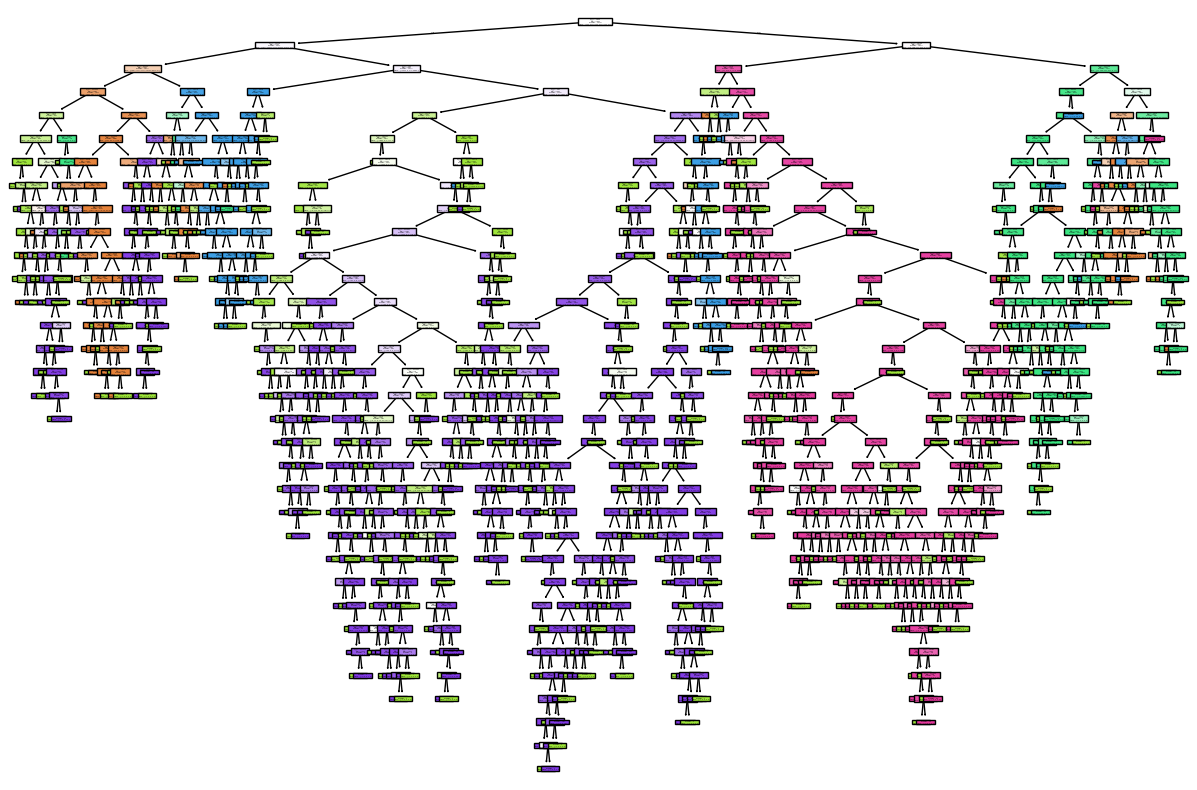

In [53]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

# It can be seen that overfitting is caused due to formation of very complex tree.

In [54]:
path = decision_tree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas,impurities = path.ccp_alphas,path.impurities
ccp_alphas

array([0.00000000e+00, 1.63482161e-05, 1.63708537e-05, 1.64453516e-05,
       1.64567826e-05, 1.85212624e-05, 1.96028658e-05, 1.97403089e-05,
       1.97560132e-05, 2.16081395e-05, 2.34602657e-05, 2.34903816e-05,
       2.35190634e-05, 2.37803863e-05, 2.38335625e-05, 2.39232973e-05,
       2.39466827e-05, 2.40275837e-05, 2.40451477e-05, 2.41070400e-05,
       2.41337662e-05, 2.41805370e-05, 2.42108005e-05, 2.42391863e-05,
       2.42901802e-05, 2.42901802e-05, 2.43901398e-05, 2.44175444e-05,
       2.44745253e-05, 2.44802773e-05, 2.44990244e-05, 2.45273085e-05,
       2.45292782e-05, 2.45497517e-05, 2.45522708e-05, 2.45530912e-05,
       2.45554967e-05, 2.45578220e-05, 2.45600711e-05, 2.45675349e-05,
       2.45762905e-05, 2.45832744e-05, 2.45876469e-05, 2.45992994e-05,
       2.46003996e-05, 2.46156113e-05, 2.46266093e-05, 2.46313149e-05,
       2.46334330e-05, 2.46361299e-05, 2.46667614e-05, 2.46670810e-05,
       2.46677795e-05, 2.46708295e-05, 2.46882079e-05, 2.46950165e-05,
      

In [55]:
# Fit decision tree for each ccp_alpha

dts = []
for ccp_alpha in ccp_alphas:
    decision_tree=DecisionTreeClassifier(random_state=SEED,ccp_alpha=ccp_alpha)
    decision_tree.fit(X_train,y_train)
    dts.append(decision_tree)
# print("Number of ")

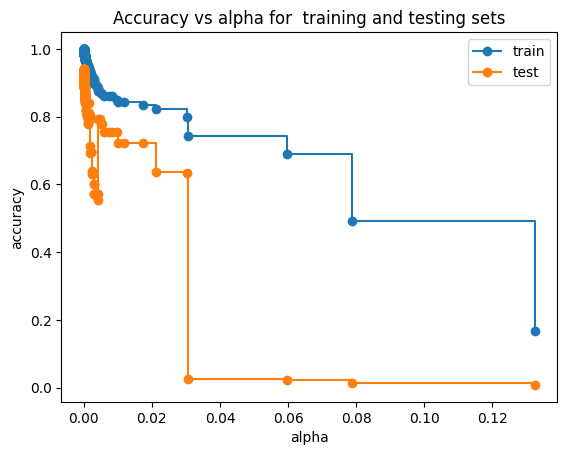

In [56]:
# calulate and plot the accuracy over training and testing dataset for each fitted decision tree
# find the optimal ccp_alpha from the plot

train_scores = [decision_tree.score(X_train,y_train) for decision_tree in dts]
test_scores = [decision_tree.score(X_test,y_test) for decision_tree in dts]

fig,ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for  training and testing sets")
ax.plot(ccp_alphas, train_scores,marker="o",label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores,marker="o",label="test",drawstyle="steps-post")
plt.legend()
plt.show()

In [57]:
# Selected optimal value of 0.0015 of ccp_alpha
# It can be observed that overfitting decreased.

decision_tree = DecisionTreeClassifier(random_state=SEED, ccp_alpha=0.005)
decision_tree.fit(X_train,y_train)
y_pred_dt = decision_tree.predict(X_test)

dt_train_accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")


Training Accuracy : 87.05 %
Model Accuracy Score : 77.7 %


[Text(0.5131578947368421, 0.9285714285714286, 'x[4] <= 188.5\ngini = 0.833\nsamples = 40494\nvalue = [6749, 6749, 6749, 6749, 6749, 6749]'),
 Text(0.2894736842105263, 0.7857142857142857, 'x[2] <= 1378.5\ngini = 0.753\nsamples = 24921\nvalue = [5931.0, 5961.0, 177.0, 6103.0, 6749.0, 0.0]'),
 Text(0.40131578947368424, 0.8571428571428572, 'True  '),
 Text(0.15789473684210525, 0.6428571428571429, 'x[3] <= 62.421\ngini = 0.602\nsamples = 10659\nvalue = [5928.0, 717.0, 177.0, 2970.0, 867.0, 0.0]'),
 Text(0.10526315789473684, 0.5, 'x[0] <= 301.502\ngini = 0.366\nsamples = 7463\nvalue = [5836, 684, 76, 0, 867, 0]'),
 Text(0.05263157894736842, 0.35714285714285715, 'gini = 0.549\nsamples = 907\nvalue = [48, 560, 76, 0, 223, 0]'),
 Text(0.15789473684210525, 0.35714285714285715, 'x[1] <= 311.9\ngini = 0.211\nsamples = 6556\nvalue = [5788, 124, 0, 0, 644, 0]'),
 Text(0.10526315789473684, 0.21428571428571427, 'gini = 0.081\nsamples = 5982\nvalue = [5732, 64, 0, 0, 186, 0]'),
 Text(0.2105263157894736

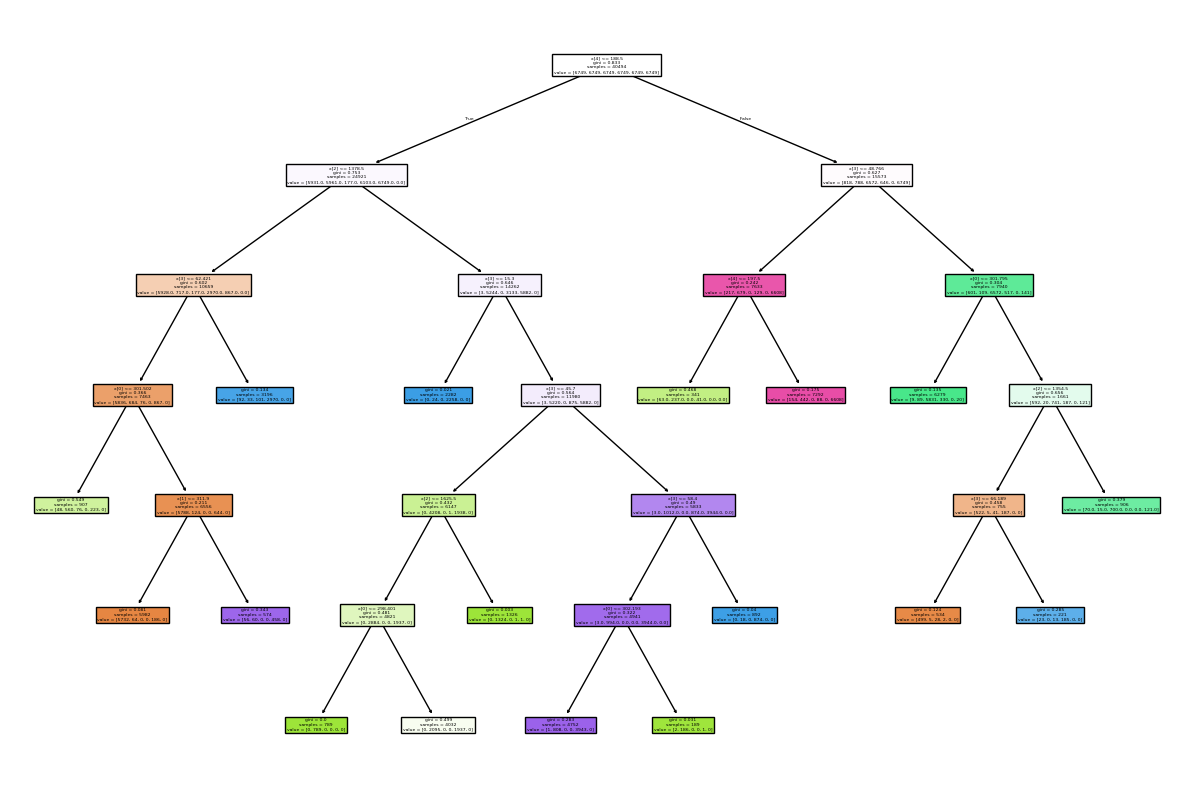

In [58]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

In [59]:
train_y = train_data["EncodedFailureType"]
classes = np.unique(train_y)
print(classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weight_dict = dict(zip(classes, class_weights))

# Assign weights to each sample manually
sample_weights = np.array([class_weight_dict[label] for label in train_y])

np.unique(sample_weights), np.unique(class_weights)

[0 1 2 3 4 5]


(array([  0.17286512,  13.10861423,  18.22916667,  20.83333333,
         37.6344086 , 106.06060606]),
 array([  0.17286512,  13.10861423,  18.22916667,  20.83333333,
         37.6344086 , 106.06060606]))

In [60]:
classes = np.unique(y_train)
print(classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Assign weights to each sample manually
sample_weights = np.array([class_weight_dict[label] for label in y_train])

np.unique(class_weights)

[0 1 2 3 4 5]


array([1.])

### Run GridSearchCV for hyperparameter tuning for each above classifier; cache results to avoid re-computation


Don't run this section again and again, run once and store the results in a session and access later

In [61]:
start = time.time()
# Define model parameters
model_params = {
    'dt':{'model':DecisionTreeClassifier(criterion='gini',random_state=SEED,ccp_alpha=0.0012, class_weight="balanced"),
          'params':{'max_depth':[5,6,7,8,10,20,30,50], 'min_samples_split':[50,100,200], 
                    'min_samples_leaf':[50,100,200]}
          },
    'random_forest': {'model': RandomForestClassifier(criterion='gini',random_state=SEED, class_weight="balanced"),
        'params': {'n_estimators': [10, 50, 100], 'max_depth':[8,10,20,30,50], 'min_samples_split':[50,100,200], 
                   'min_samples_leaf':[50,100,200]}
            }
}

# Perform grid search and store results
scores_multi = []
for model_name, mp in model_params.items():
    print(model_name)
    print(mp)
    classifier = GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=True)
    classifier.fit(X_train.values, y_train.values, sample_weight=sample_weights)
    scores_multi.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'mean_train_score': np.mean(classifier.cv_results_['mean_train_score']),
            })
    print(scores_multi)

# Create DataFrame from scores
df = pd.DataFrame(scores_multi, columns=['model', 'best_score', 'best_params', 'mean_train_score'])

# Print the results
df

end = time.time()

print(f"Time taken {(end-start)/60} mins")

%store scores_multi


dt
{'model': DecisionTreeClassifier(ccp_alpha=0.0012, class_weight='balanced',
                       random_state=42), 'params': {'max_depth': [5, 6, 7, 8, 10, 20, 30, 50], 'min_samples_split': [50, 100, 200], 'min_samples_leaf': [50, 100, 200]}}
[{'model': 'dt', 'best_score': np.float64(0.9443867194765359), 'best_params': {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': np.float64(0.9085192514383498)}]
random_forest
{'model': RandomForestClassifier(class_weight='balanced', random_state=42), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [8, 10, 20, 30, 50], 'min_samples_split': [50, 100, 200], 'min_samples_leaf': [50, 100, 200]}}
[{'model': 'dt', 'best_score': np.float64(0.9443867194765359), 'best_params': {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': np.float64(0.9085192514383498)}, {'model': 'random_forest', 'best_score': np.float64(0.9623893599699972), 'best_params': {'max_depth': 30, 'min_sam

In [62]:
%store -r scores_multi

In [63]:
scores_multi[0]['best_params']

{'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [64]:
scores_multi[1]['best_params']['n_estimators'],

(100,)

### Instantiate classifiers using optimal hyperparameters selected via GridSearchCV

In [65]:
dt_multi_clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.005, random_state=SEED, 
                                      max_depth=scores_multi[0]['best_params']['max_depth'],
                                      min_samples_leaf=scores_multi[0]['best_params']['min_samples_leaf'],
                                      min_samples_split=scores_multi[0]['best_params']['min_samples_split'],
                                      class_weight="balanced")


rf_multi_clf = RandomForestClassifier(criterion='gini', random_state=SEED, 
                                      max_depth=scores_multi[1]['best_params']['max_depth'],
                                      n_estimators=scores_multi[1]['best_params']['n_estimators'],
                                      min_samples_leaf=scores_multi[1]['best_params']['min_samples_leaf'],
                                      min_samples_split=scores_multi[1]['best_params']['min_samples_split'],
                                      class_weight="balanced")

In [66]:
# dt_multi_clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0015, random_state=1, 
#                                       max_depth=scores_multi[0]['best_params']['max_depth'],
#                                       min_samples_leaf=scores_multi[0]['best_params']['min_samples_leaf'],
#                                       min_samples_split=scores_multi[0]['best_params']['min_samples_split'],
#                                       class_weight="balanced")

# svc_multi_clf = SVC(gamma='auto', random_state=1, C=scores_multi[1]['best_params']['C'], 
#                     kernel=scores_multi[1]['best_params']['kernel'], class_weight="balanced")

# rf_multi_clf = RandomForestClassifier(criterion='gini', random_state=1, 
#                                       max_depth=scores_multi[2]['best_params']['max_depth'],
#                                       n_estimators=scores_multi[2]['best_params']['n_estimators'],
#                                       min_samples_leaf=scores_multi[2]['best_params']['min_samples_leaf'],
#                                       min_samples_split=scores_multi[2]['best_params']['min_samples_split'],
#                                       class_weight="balanced")

# lr_multi_clf = LogisticRegression(penalty='l2', random_state=1, C=scores_multi[3]['best_params']['C'],
#                                   max_iter=150,class_weight="balanced")

### Using Stratified K-Fold Cross Validation for evaluating the models after initializing them with best hyperparameters chosen set

In [67]:
def get_score(model,stratified_kfold):
    
    cv_results = cross_validate(model, X_train, y_train, cv=stratified_kfold, return_train_score=True,
                            scoring='f1_macro')

    print("****" * 4)
    print(model)
    print('Train Scores:', cv_results['train_score'])
    print('Test Scores:', cv_results['test_score'])
    print('Average Train Accuracy:', np.mean(cv_results['train_score']))
    print('Average Test Accuracy:', np.mean(cv_results['test_score']))
    print("****" * 4)

models = [dt_multi_clf,rf_multi_clf]
#models=[svc_multi_clf,lr_multi_clf,dt_multi_clf,rf_multi_clf]
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for model in models:
    get_score(model,stratified_kfold)

****************
DecisionTreeClassifier(ccp_alpha=0.005, class_weight='balanced', max_depth=20,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)
Train Scores: [0.87023926 0.86852368 0.8741269  0.86928336 0.86994457 0.86855238
 0.86953651 0.86908617 0.87201185 0.87244581]
Test Scores: [0.85713708 0.87228352 0.86638375 0.86621348 0.86954536 0.87257595
 0.87384215 0.86773025 0.87618941 0.8725175 ]
Average Train Accuracy: 0.8703750496365602
Average Test Accuracy: 0.8694418433613326
****************
****************
RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)
Train Scores: [0.96580444 0.9652462  0.96658271 0.96623101 0.96608503 0.96628186
 0.96544521 0.96548162 0.96650392 0.96574025]
Test Scores: [0.95795603 0.96484469 0.96400522 0.96299147 0.964391   0.9609155
 0.96262613 0.96602681 0.96251898 0.96231344]
Averag

### Gradient boosted classifiers: XGBoost

#### Fit and evaluate Xgboost with default/random hyperparameters

In [68]:
xgboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                         max_depth=1, random_state=SEED).fit(X_train, y_train)
xgboost_clf.score(X_test, y_test)

0.7916666666666666

#### Fine tune Xgboost classifier

In [69]:
# Define model parameters
model_params = {
    'xgboost':{'model':GradientBoostingClassifier(random_state=SEED),
          'params':{'max_depth':[1,5,10,50],'n_estimators':[10,50,100],'learning_rate':[0.01,0.05,0.1,1]}
          }
}

# Perform grid search and store results
scores_multi_xgboost = []
for model_name, mp in model_params.items():
    print(model_name)
    print("Parameters",mp)
    classifier = GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=True) #this will create a GridSearchCV object
    classifier.fit(X_train.values, y_train.values, sample_weight=sample_weights) #This will fit the GridSearchCV on the whole data, but during fitting cross-validation will be 
                                       #performed on the training data to tune the hyperparameters and select the best model.
    scores_multi_xgboost.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'mean_train_score': np.mean(classifier.cv_results_['mean_train_score']),
            })
    print(scores_multi_xgboost)

# Create DataFrame from scores
df_xgboost = pd.DataFrame(scores_multi_xgboost, columns=['model', 'best_score', 'best_params', 'mean_train_score'])

# Print the results
df_xgboost


xgboost
Parameters {'model': GradientBoostingClassifier(random_state=42), 'params': {'max_depth': [1, 5, 10, 50], 'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.05, 0.1, 1]}}
[{'model': 'xgboost', 'best_score': np.float64(0.9939497635447252), 'best_params': {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}, 'mean_train_score': np.float64(0.9311653697158805)}]


,model,best_score,best_params,mean_train_score
0,xgboost,0.99395,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.931165


In [70]:
%store scores_multi_xgboost

Stored 'scores_multi_xgboost' (list)


#### Initialize the model with best hyperparamters

In [71]:
%store -r scores_multi_xgboost

In [72]:
scores_multi_xgboost[0]['best_params']

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [73]:
xgboost_multi_clf = GradientBoostingClassifier(random_state=SEED, max_depth=scores_multi_xgboost[0]['best_params']['max_depth'],
                                              learning_rate=scores_multi_xgboost[0]['best_params']['learning_rate'],
                                              n_estimators=scores_multi_xgboost[0]['best_params']['n_estimators'])

#### Model evaluation using stratified-kfold technique

In [74]:
def get_score(model,stratified_kfold):
    cv_results = cross_validate(model, X_train, y_train, cv=stratified_kfold, return_train_score=True,
                                scoring='f1_macro')

    print("****" * 4)
    print(model)
    print('Train Scores:', cv_results['train_score'])
    print('Test Scores:', cv_results['test_score'])
    print('Average Train Accuracy:', np.mean(cv_results['train_score']))
    print('Average Test Accuracy:', np.mean(cv_results['test_score']))
    print("****" * 4)

models=[xgboost_multi_clf]
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for model in models:
    get_score(model,stratified_kfold)

****************
GradientBoostingClassifier(max_depth=10, random_state=42)
Train Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores: [0.99154772 0.99578762 0.99403969 0.99355212 0.99479058 0.99254022
 0.99304887 0.99330292 0.99553336 0.99579041]
Average Train Accuracy: 1.0
Average Test Accuracy: 0.9939933505057399
****************


In [75]:
xgboost_multi_clf

GradientBoostingClassifier(max_depth=10, random_state=42)

#### Fitting and evaluating the model

In [76]:
xgboost_multi_clf.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier(max_depth=10, random_state=42)

In [77]:
y_pred = xgboost_multi_clf.predict(X_test)
print(np.unique(y_pred))
y_pred_df = pd.DataFrame({'Predicted': y_pred})

# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test)  # Assuming X_test is a DataFrame

#X_test_df.info()
#y_pred_df.info()

# Concatenate y_pred_df and X_test_df along the columns
X_test_df.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)
result_df = pd.concat([X_test_df, y_pred_df], axis=1)
result_df["Predicted"].unique()


[0 1 2 3 4 5]


array([1, 5, 0, 3, 2, 4])

In [78]:
confusion_matrix(y_test, y_pred)

array([[  22,    1,    0,    0,    0,    0],
       [   1, 2820,    5,   10,   23,   44],
       [   0,    7,   14,    0,    0,    1],
       [   0,    3,    0,   28,    0,    0],
       [   0,    7,    0,    0,    0,    0],
       [   0,    7,    1,    0,    0,    6]])

In [79]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.99      0.97      0.98      2903
           2       0.70      0.64      0.67        22
           3       0.74      0.90      0.81        31
           4       0.00      0.00      0.00         7
           5       0.12      0.43      0.18        14

    accuracy                           0.96      3000
   macro avg       0.58      0.65      0.60      3000
weighted avg       0.98      0.96      0.97      3000



### Evaluate all classifiers using classification measures

#### Random Forest

In [80]:
rf_multi_clf.fit(X_train,y_train, sample_weight=sample_weights)
y_pred = rf_multi_clf.predict(X_test)
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5])

In [81]:
confusion_matrix(y_test, y_pred)

array([[  23,    0,    0,    0,    0,    0],
       [  33, 2480,   30,   20,  177,  163],
       [   2,    1,   15,    2,    0,    2],
       [   0,    0,    1,   30,    0,    0],
       [   0,    5,    0,    0,    1,    1],
       [   0,    3,    1,    0,    0,   10]])

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        23
           1       1.00      0.85      0.92      2903
           2       0.32      0.68      0.43        22
           3       0.58      0.97      0.72        31
           4       0.01      0.14      0.01         7
           5       0.06      0.71      0.11        14

    accuracy                           0.85      3000
   macro avg       0.39      0.73      0.46      3000
weighted avg       0.98      0.85      0.91      3000



#### Decision Tree

In [83]:
dt_multi_clf.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = dt_multi_clf.predict(X_test)
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5])

In [84]:
confusion_matrix(y_test, y_pred)

array([[  17,    0,    0,    1,    3,    2],
       [  20, 2256,   45,   21,  331,  230],
       [   2,    1,   16,    2,    0,    1],
       [   0,    0,    3,   28,    0,    0],
       [   0,    5,    0,    0,    1,    1],
       [   0,    0,    1,    0,    0,   13]])

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.74      0.55        23
           1       1.00      0.78      0.87      2903
           2       0.25      0.73      0.37        22
           3       0.54      0.90      0.67        31
           4       0.00      0.14      0.01         7
           5       0.05      0.93      0.10        14

    accuracy                           0.78      3000
   macro avg       0.38      0.70      0.43      3000
weighted avg       0.98      0.78      0.86      3000



### Dump the trained classifiers in a pickle file
(Chose xgboost and random forest as the best classifiers).

In our problem following matters a lot: 
- False Negative (missed failure) is very costly, it leads to unplanned downtime, damage, or safety risks.
- False Positive (false alarm) might just result in extra inspection/maintenance, which is usually acceptable.

Algorithm's performance based on following criteria:
- Based on macro F1 score: Xgboost classifier>Random Forest>Decision Tree
- Based on recall and precision on each class: Random forest>Decision Tree>XgBoost

In my observation, I would go ahead with selecting Xgboost and random forest as the best classifiers for following reasons for two different scenarios, whichever is costlier:
- If objective is avoiding missed failures, then one should go with random forest, as less instances in comparison to xgboost have been misclassified to class 1 (class 1 corresponds to not a failure).
- If objective is avoiding false alarms, then one should go with Xgboost, as less instances in comparison to random forest have been misclassified as failures, when they were not failures.


In [86]:
model_path = r"D:\Machine Predictive Maintenance Classification Dataset\models\multinomial_classifiers"

random_forest_model_path = os.path.join(model_path, "random_forest_multi_clf.pkl")

pickle_out = open(random_forest_model_path, "wb")
pickle.dump(rf_multi_clf, pickle_out)
pickle_out.close()

In [87]:
model_path = r"D:\Machine Predictive Maintenance Classification Dataset\models\multinomial_classifiers"

xgboost_model_path = os.path.join(model_path, "xgboost_multi_clf.pkl")

pickle_out = open(xgboost_model_path, "wb")
pickle.dump(xgboost_multi_clf, pickle_out)
pickle_out.close()

### Pedict on test data

In [88]:
label_encoder_path = r"D:\Machine Predictive Maintenance Classification Dataset\models\label_encoder"

encoder_path = os.path.join(label_encoder_path, "failure_type_encoder.pkl")
# Pickle the label encoder
with open(encoder_path, "wb") as label_encoder_file: #label_encoder
    pickle.dump(failure_type_encoder, label_encoder_file)

In [89]:
test_data = pd.read_csv(r"D:\Machine Predictive Maintenance Classification Dataset\data\TestFile.csv")
test_data

,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear
0,300.0,300.0,1500,40.0,30
1,290.0,290.0,1400,39.0,29
2,298.9,309.1,2861,4.6,143
3,98.9,309.0,1410,65.7,191
4,305.0,200.0,150,15.0,1
5,285.0,200.0,1400,40.0,25
6,300.5,309.9,1397,45.9,210
7,300.3,311.7,1545,43.5,160


In [90]:
prediction = rf_multi_clf.predict(test_data)
prediction

array([1, 1, 3, 3, 0, 1, 5, 1])

In [91]:
prediction = xgboost_multi_clf.predict(test_data)
prediction

array([1, 1, 3, 3, 3, 1, 5, 1])

In [92]:
failure_type_encoder.inverse_transform(prediction)

array(['No Failure', 'No Failure', 'Power Failure', 'Power Failure',
       'Power Failure', 'No Failure', 'Tool Wear Failure', 'No Failure'],
      dtype=object)